In [2]:
import torch as th
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import os
os.environ["DGLBACKEND"] = "pytorch"
import dgl
import dgl.function as fn
import dgl.nn as gnn
import pickle
from tqdm import tqdm

import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)
import category_encoders as ce
from sklearn.preprocessing import StandardScaler
# import faiss


In [3]:
class NegativeSamplerRel:
    def __init__(self, k=1):
        self.k = k

    def __call__(self, g):
        src, dst, eid = g.edges(form='all')
        etypes = g.edata['type'][eid]
        pos_samples = th.column_stack([src, etypes, dst])
        # pos_samples: [u, r, v]
        batch_size = len(pos_samples)
        neg_batch_size = batch_size * self.k
        neg_samples = th.tile(pos_samples, (self.k, 1))

        values = th.randint(g.num_nodes(), size=(neg_batch_size, ))
        choices = th.rand(size=(neg_batch_size, ))
        subj = choices > 0.5
        obj = choices <= 0.5
        neg_samples[subj, 0] = values[subj]
        neg_samples[obj, 2] = values[obj]

        neg_graph = dgl.graph((neg_samples[:, 0], neg_samples[:, 2]), num_nodes=g.num_nodes())
        neg_graph.edata['type'] = neg_samples[:, 1]
        
        return neg_graph

class RGCN(nn.Module):
    def __init__(self, in_feats, n_hidden, n_classes, n_layers, activation, dropout, n_rels):
        super().__init__()
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.n_classes = n_classes
        self.layers = nn.ModuleList()
        if n_layers > 1:
            self.layers.append(gnn.RelGraphConv(in_feats, n_hidden, num_rels=n_rels)) 
            for i in range(1, n_layers - 1):
                self.layers.append(gnn.RelGraphConv(n_hidden, n_hidden, num_rels=n_rels))
            self.layers.append(gnn.RelGraphConv(n_hidden, n_classes, num_rels=n_rels))
        else:
            self.layers.append(gnn.RelGraphConv(in_feats, n_classes, num_rels=n_rels, low_mem=True))
        self.dropout = nn.Dropout(dropout)
        self.activation = activation

    def forward(self, g, x):
        h = x
        etypes = g.edata['type']
        norm = g.edata['norm'].view(-1, 1)
        for l, layer in enumerate(self.layers):
            h = layer(g, h, etypes, norm)
            if l != len(self.layers) - 1:
                h = self.activation(h)
                h = self.dropout(h)
        return h

class LinkPredictor(nn.Module):
    def __init__(self, rgcn, reg_param=0.01):
        super().__init__()
        self.rgcn = rgcn
        self.reg_param = reg_param
        self.w_relation = nn.Parameter(th.Tensor(n_rels, self.rgcn.n_classes))
        nn.init.xavier_uniform_(self.w_relation,
                                gain=nn.init.calculate_gain('relu'))

    def forward(self, g, x):
        return F.dropout(self.rgcn(g, x), p=0.2)
    
    def calc_score(self, embedding, graph):
        # DistMult
        src, dst, eid = graph.edges(form='all')
        etypes = graph.edata['type'][eid]
        s = embedding[src]
        r = self.w_relation[etypes]
        o = embedding[dst]
        score = th.sum(s * r * o, dim=1)
        return score
    
    def regularization_loss(self, embedding):
        return th.mean(embedding.pow(2)) + th.mean(self.w_relation.pow(2))

    def get_loss(self, embed, pos_graph, neg_graph):
        pos_score = self.calc_score(embed, pos_graph)
        neg_score = self.calc_score(embed, neg_graph)
        score = th.cat([pos_score, neg_score])
        label = th.cat([th.ones_like(pos_score), th.zeros_like(neg_score)]).long()
        predict_loss = F.binary_cross_entropy_with_logits(score, label.float())

        reg_loss = self.regularization_loss(embed)
        return predict_loss + self.reg_param * reg_loss

In [4]:
with open('../data/graph/okved_graph_new.pickle', 'rb') as fp:
    g = pickle.load(fp)

# probably we could change the importance of different edge types
# by weighting them here ? 
# etype_weight = th.FloatTensor([0.0, 1.0, 0.0])
# g.edata['norm'] = g.edata['norm'] * etype_weight[g.edata['type']]

In [5]:
num_negs = 1
neg_share = False
device = th.device('cpu')
num_hidden = 256
num_layers = 2
dropout = 0.25
lr = 3e-4
num_epochs = 10_000
best_loss = 1000000 
last_improvement = 0
require_improvements = 50
best_state = None
n_rels = 4
reg_param = 0

nfeat = g.ndata['feat'].float().to(device)
in_feats = nfeat.shape[1]
n_edges = g.num_edges()

rgcn = RGCN(in_feats, num_hidden, num_hidden, num_layers, F.relu, dropout, n_rels)
model = LinkPredictor(rgcn, reg_param=reg_param)
sampler = NegativeSamplerRel(k=num_negs)
optimizer = optim.Adam(model.parameters(), lr=lr)
losses = []
for epoch in range(num_epochs):
    neg_graph = sampler(g).to(device)
    # Compute loss and prediction
    pred = model(g, nfeat)
    loss = model.get_loss(pred, g, neg_graph)
    optimizer.zero_grad()
    loss.backward()
    # nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) # clip gradients
    optimizer.step()
    print(f'Epoch {epoch:05d} |  Loss {loss.item():.4f}')

    if loss.item() < best_loss:
        best_loss = loss.item()
        last_improvement = 0
        best_state = model.state_dict()
    else:
        last_improvement += 1
    if last_improvement > require_improvements:
        print(f"No improvement found during the {require_improvements} last iterations, stopping optimization.")
        model.load_state_dict(best_state)
        break

Epoch 00000 |  Loss 0.6906
Epoch 00001 |  Loss 0.6711
Epoch 00002 |  Loss 0.6602
Epoch 00003 |  Loss 0.6480
Epoch 00004 |  Loss 0.6347
Epoch 00005 |  Loss 0.6250
Epoch 00006 |  Loss 0.6144
Epoch 00007 |  Loss 0.6084
Epoch 00008 |  Loss 0.6058
Epoch 00009 |  Loss 0.5983
Epoch 00010 |  Loss 0.5906
Epoch 00011 |  Loss 0.5824
Epoch 00012 |  Loss 0.5794
Epoch 00013 |  Loss 0.5750
Epoch 00014 |  Loss 0.5697
Epoch 00015 |  Loss 0.5665
Epoch 00016 |  Loss 0.5609
Epoch 00017 |  Loss 0.5547
Epoch 00018 |  Loss 0.5497
Epoch 00019 |  Loss 0.5484
Epoch 00020 |  Loss 0.5424
Epoch 00021 |  Loss 0.5389
Epoch 00022 |  Loss 0.5339
Epoch 00023 |  Loss 0.5300
Epoch 00024 |  Loss 0.5278
Epoch 00025 |  Loss 0.5243
Epoch 00026 |  Loss 0.5208
Epoch 00027 |  Loss 0.5168
Epoch 00028 |  Loss 0.5155
Epoch 00029 |  Loss 0.5129
Epoch 00030 |  Loss 0.5108
Epoch 00031 |  Loss 0.5066
Epoch 00032 |  Loss 0.5074
Epoch 00033 |  Loss 0.5036
Epoch 00034 |  Loss 0.5015
Epoch 00035 |  Loss 0.4991
Epoch 00036 |  Loss 0.4977
E

KeyboardInterrupt: 

In [6]:
model.eval()
embeddings_model = model(g, nfeat).detach().numpy()[1:2637]
embeddings_model_2d = TSNE(n_components=2).fit_transform(embeddings_model)

c:\Users\egrli\envs\okved_embeddings\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] Не удается найти указанный файл
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\egrli\envs\okved_embeddings\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "C:\Users\egrli\AppData\Local\Programs\Python\Python310\lib\subprocess.py", line 501, in run
    with Popen(*popenargs, **kwargs) as process:
  File "C:\Users\egrli\AppData\Local\Programs\Python\Python310\lib\subprocess.py", line 966, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\egrli\AppData\Local\Programs\Python\Python310\lib\subprocess.py", line 1435, in _execute_child
    h

In [7]:
embeddings_model_2d.shape

(2636, 2)

In [8]:
embeddings_model_2d.shape

(2636, 2)

In [9]:
# np.save(f'../embeddings/embeddings_loss_{version_name}.npy', embeddings_model)

In [10]:
okved_data = pd.read_csv('../data/okved2/okved_2014_w_sections.csv', index_col=0)
sections = okved_data['section_id'].values

In [11]:
# embeddings_model = np.load(f'../embeddings/embeddings_loss_{version_name}.npy')
# embeddings_model_2d = TSNE(n_components=2).fit_transform(embeddings_model)

In [12]:
# np.save('tsne_embeddings.npy', embeddings_model_2d)
# embeddings_model_2d = np.load('tsne_embeddings.npy')

In [13]:
sections.shape

(2636,)

In [19]:
from training_utils import eval_model, get_embs_and_plot

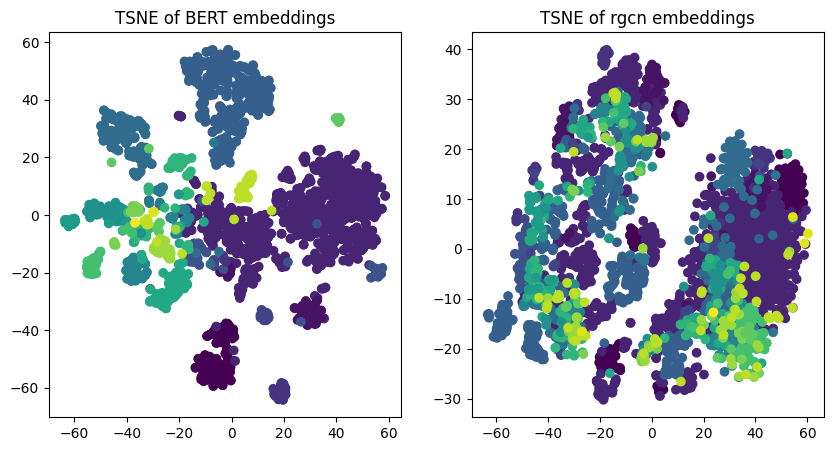

In [24]:
get_embs_and_plot(embeddings_model,'rgcn', 'rgcn', 'rgcn', sections=sections)

Text(0.5, 1.0, 't-SNE embeddings of OKVED codes R-GCN')

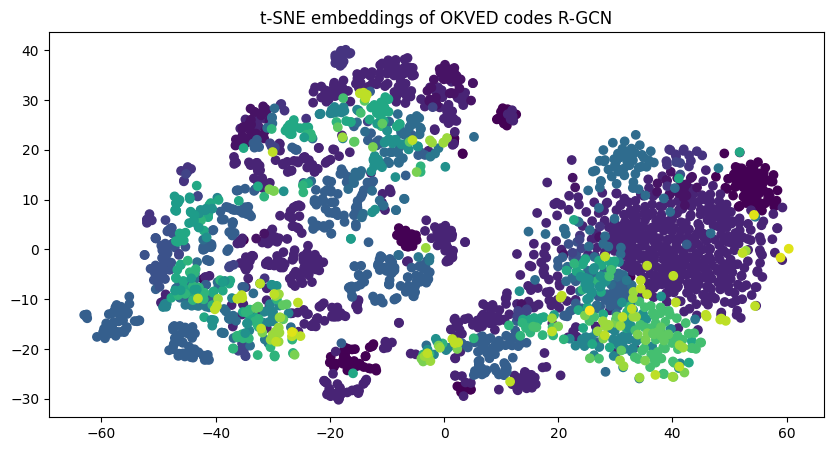

In [25]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(embeddings_model_2d[:sections.shape[0], 0], embeddings_model_2d[:sections.shape[0], 1], c=sections)
ax.set_title('t-SNE embeddings of OKVED codes R-GCN')

In [15]:
import faiss
dim = embeddings_model.shape[1]
index = faiss.IndexFlatL2(dim)
index.add(embeddings_model)

In [16]:
topn = 7
# 10 608 342 1419 1761 1305
# 47 1279 1191 107 2622 631
# 1973
idx = np.random.randint(0, len(okved_data))
# idx = 1305
from random import shuffle
with open('results.txt', 'w', encoding='utf8') as fp:
    order = list(range(len(okved_data)))
    shuffle(order)
    for idx in tqdm(order):
        # print(idx)
        D, I = index.search(embeddings_model[[idx]], topn)
        data = okved_data['native_code'] + ' ' + okved_data['name_okved']
        closest = data.iloc[I[0]].tolist()
        closest_s = '\n'.join(closest)
        fp.write(f"{idx}\n{closest_s}\n\n")

  0%|          | 0/2636 [00:00<?, ?it/s]

100%|██████████| 2636/2636 [00:03<00:00, 764.72it/s] 


In [26]:
topn = 10
idx = 2200

D, I = index.search(embeddings_model[[idx]], topn)
data = okved_data['native_code'] + ' ' + okved_data['name_okved']
closest = data.iloc[I[0]].tolist()
closest, D

(['72.19 Научные исследования и разработки в области естественных и технических наук прочие',
  '70.22 Консультирование по вопросам коммерческой деятельности и управления',
  '69.1 Деятельность в области права',
  '73.11 Деятельность рекламных агентств',
  '82.99 Деятельность по предоставлению прочих вспомогательных услуг для бизнеса, не включенная в другие группировки',
  '62.09 Деятельность, связанная с использованием вычислительной техники и информационных технологий, прочая',
  '33.13 Ремонт электронного и оптического оборудования',
  '62.01 Разработка компьютерного программного обеспечения',
  '68.2 Аренда и управление собственным или арендованным недвижимым имуществом',
  '42.21 Строительство инженерных коммуникаций для водоснабжения и водоотведения, газоснабжения'],
 array([[ 0.      , 23.780056, 23.87851 , 23.986065, 24.617203, 26.136234,
         26.208767, 27.093834, 27.151058, 27.526077]], dtype=float32))

In [17]:
def cut(s: str, ln: int = 10) -> str:
    if len(s) >= ln:
        return s[:ln - 3] + '...'
    return s
    
def draw_2d(embeddings_2d: np.array,
            names: list,
            colors: list,
            xlim: tuple = None,
            ylim: tuple = None,
            figsize: tuple = (15, 5),
            annotate: bool = False,
            hide_spins: tuple = None,
            node_size: int = 5) -> None:
    """
    Рисует проекции эмбеддингов на плоскости
    Args:
        embeddings_2d (np.array): массив эмбеддингов узлов
        g (dgl.DGLHeteroGraph): граф для обучения
        okved_data (pd.DataFrame): таблица с информацией об ОКВЭД
        okved_to_section (dict): маппинг код раздела ОКВЭД - номер кода
        idx_to_okved (dict): маппинг номер кода ОКВЭД - код
        xlim (tuple, optional): ограничения по оси х
        ylim (tuple, optional): ограничения по оси у
        figsize (tuple, optional): размер фигуры
        annotate (bool, optional): True, если нужно добавить подписи к точкам (лучше не применять на полном датасете)
        name_len (int, optional): максимальная длина названия кода
        hide_spins (tuple, optional): какие рамки скрывать
        node_size (int, optional): размер точки
    """
    fig, ax = plt.subplots(figsize=figsize)
    if xlim:
        x_mask = (embeddings_2d[:, 0] >= xlim[0]) & (embeddings_2d[:, 0] <= xlim[1])
    else:
        x_mask = np.ones(len(embeddings_2d)).astype(bool)
    if ylim:
        y_mask = (embeddings_2d[:, 1] >= ylim[0]) & (embeddings_2d[:, 1] <= ylim[1])

    else:
        y_mask = np.ones(len(embeddings_2d)).astype(bool)

    mask = x_mask & y_mask
    embs = embeddings_2d[mask]

    colors = colors[mask]
    names = names[mask]
    ax.scatter(embs[:, 0], embs[:, 1], s=node_size, c=colors)
    ax.set_xlabel('$h_0(v)$')
    ax.set_ylabel('$h_1(v)$')
    if annotate:
        for (x, y), txt in zip(embs, names):
            ax.text(x, y, txt, rotation=45)
    if xlim:
        ax.set_xlim(*xlim)
    if ylim:
        ax.set_ylim(*ylim)
    if hide_spins is not None:
        for spin in hide_spins:
            ax.spines[spin].set_visible(False)
    ax.set_title('Fragment of an illustration of t-SNE on OKVED code embeddings ', y=1.8, pad=-14)

In [18]:
okved_data[okved_data['native_code']=='46.72.21'].index[0]-1

1507

In [19]:
names = (okved_data['native_code'] + ': ' + okved_data['name_okved']).apply(cut, ln=50)
colors = okved_data['section_id'].values

In [20]:
embeddings_model_2d[2200], embeddings_model_2d[1507]

(array([-39.33491  ,  -7.5034018], dtype=float32),
 array([-11.413174  ,   0.70493114], dtype=float32))

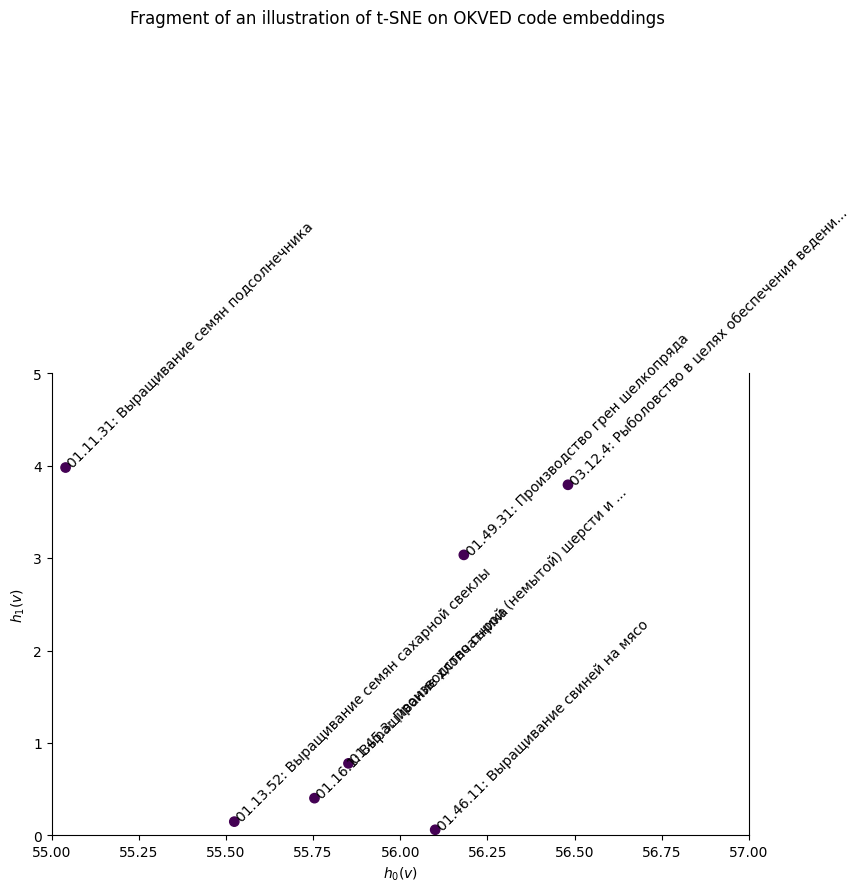

In [21]:
draw_2d(embeddings_model_2d, names, colors, 
        xlim=(55, 57), ylim=(0, 5), 
        figsize=(9, 6), annotate=True,
        node_size=45,
        hide_spins=('top', ))

In [31]:
num_negs = 1
neg_share = False
device = th.device('cpu')
num_hidden = 256
num_layers_lst = [2, 3, 4]
dropout = 0.25
lrs = [0.01, 0.001, 3e-4]
num_epochs = 100
all_losses = []

In [32]:
from tqdm.notebook import tqdm

In [33]:
for lr in tqdm(lrs):
    for num_layers in num_layers_lst:
        best_loss = 1000000 
        last_improvement = 0
        require_improvements = 50
        best_state = None
        n_rels = 4
        reg_param = 0

        nfeat = g.ndata['feat'].float().to(device)
        in_feats = nfeat.shape[1]
        n_edges = g.num_edges()

        rgcn = RGCN(in_feats, num_hidden, num_hidden, num_layers, F.relu, dropout, n_rels)
        model = LinkPredictor(rgcn, reg_param=reg_param)
        sampler = NegativeSamplerRel(k=num_negs)
        optimizer = optim.Adam(model.parameters(), lr=lr)
        losses = []
        for epoch in tqdm(range(num_epochs)):
            neg_graph = sampler(g).to(device)
            # Compute loss and prediction
            pred = model(g, nfeat)
            loss = model.get_loss(pred, g, neg_graph)
            optimizer.zero_grad()
            loss.backward()
            # nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) # clip gradients
            optimizer.step()
            # print(f'Epoch {epoch:05d} |  Loss {loss.item():.4f}')

            if loss.item() < best_loss:
                best_loss = loss.item()
                last_improvement = 0
                best_state = model.state_dict()
            else:
                last_improvement += 1
            if last_improvement > require_improvements:
                print(f"No improvement found during the {require_improvements} last iterations, stopping optimization.")
                model.load_state_dict(best_state)
                break
            losses.append(loss.item())
        all_losses[(lr, num_layers)] = losses
        print('---')

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

---


  0%|          | 0/100 [00:00<?, ?it/s]

---


  0%|          | 0/100 [00:00<?, ?it/s]

---


  0%|          | 0/100 [00:00<?, ?it/s]

---


  0%|          | 0/100 [00:00<?, ?it/s]

---


  0%|          | 0/100 [00:00<?, ?it/s]

---


  0%|          | 0/100 [00:00<?, ?it/s]

---


  0%|          | 0/100 [00:00<?, ?it/s]

---


  0%|          | 0/100 [00:00<?, ?it/s]

---


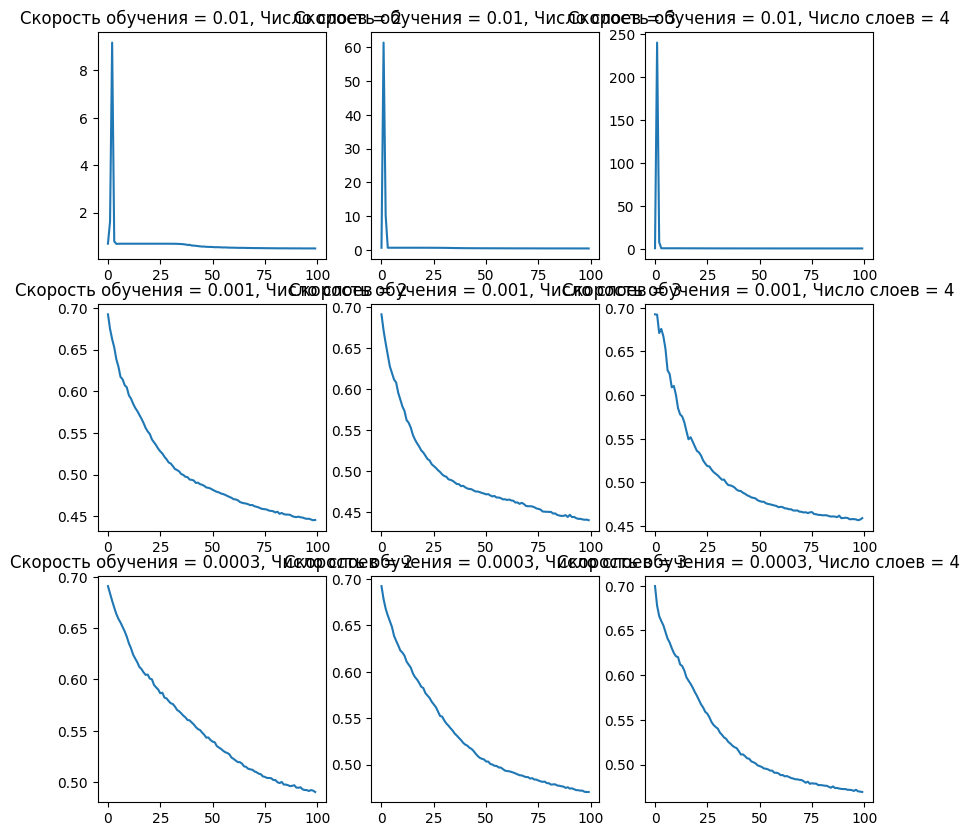

In [34]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))
for k, ax in zip(all_losses, axs.flatten()):
    ax.plot(all_losses[k])
    ax.set_title(f"Скорость обучения = {k[0]}, Число слоев = {k[1]}")

In [35]:
best_loss = 1000000 
last_improvement = 0
require_improvements = 50
best_state = None
n_rels = 4
reg_param = 0
num_layers = 3
lr = 0.001
num_negs = 1
neg_share = False
device = th.device('cpu')
num_hidden = 256
dropout = 0.2
num_epochs = 10_000
all_losses = []
nfeat = g.ndata['feat'].float().to(device)
in_feats = nfeat.shape[1]
n_edges = g.num_edges()

rgcn = RGCN(in_feats, num_hidden, num_hidden, num_layers, F.relu, dropout, n_rels)
model = LinkPredictor(rgcn, reg_param=reg_param)
sampler = NegativeSamplerRel(k=num_negs)
optimizer = optim.Adam(model.parameters(), lr=lr)
losses = []
for epoch in tqdm(range(num_epochs)):
    neg_graph = sampler(g).to(device)
    # Compute loss and prediction
    pred = model(g, nfeat)
    loss = model.get_loss(pred, g, neg_graph)
    optimizer.zero_grad()
    loss.backward()
    # nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) # clip gradients
    optimizer.step()
    # print(f'Epoch {epoch:05d} |  Loss {loss.item():.4f}')

    if loss.item() < best_loss:
        best_loss = loss.item()
        last_improvement = 0
        best_state = model.state_dict()
    else:
        last_improvement += 1
    if last_improvement > require_improvements:
        print(f"No improvement found during the {require_improvements} last iterations, stopping optimization.")
        model.load_state_dict(best_state)
        break
    losses.append(loss.item())

  0%|          | 0/10000 [00:00<?, ?it/s]

No improvement found during the 50 last iterations, stopping optimization.


In [36]:
best_loss

0.34855175018310547

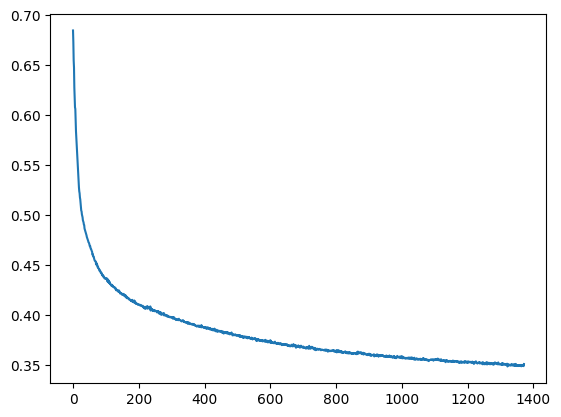

In [37]:
plt.plot(losses)

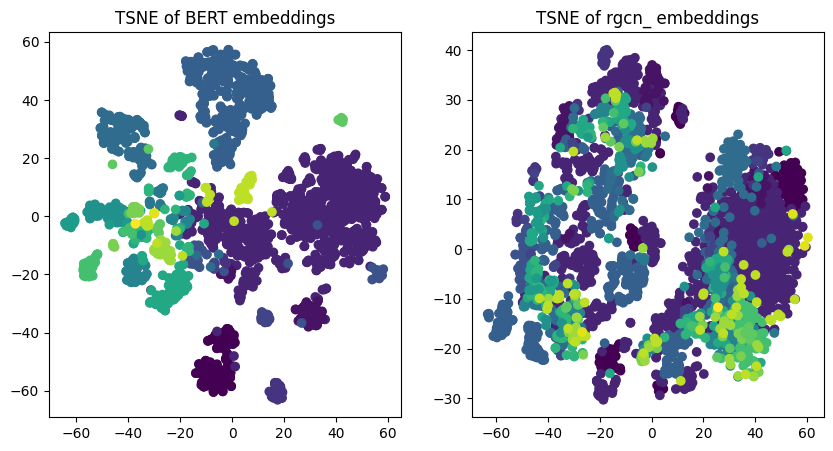

In [38]:
get_embs_and_plot(embeddings_model,'rgcn_', 'rgcn_', 'rgcn_', sections=sections)

In [39]:
eval_model(version_name='rgcn_')

  1%|          | 1/100 [00:07<11:44,  7.11s/it]c:\Users\egrli\envs\okved_embeddings\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
  5%|▌         | 5/100 [00:26<08:46,  5.55s/it]c:\Users\egrli\envs\okved_embeddings\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


([-0.13298785783471723,
  -3.131889340776768,
  -0.01465038001592367,
  -0.4946350156880559,
  0.3684495776826546,
  -0.7373672959446262,
  0.27950692974651625,
  0.1924880345480382,
  0.6405755553685284,
  0.2280358140277412,
  -0.9726715632007445,
  0.4010396611573577,
  -0.5910705394894631,
  0.478544171338505,
  0.4418543523234293,
  0.4866819032605958,
  0.23781265910832627,
  -0.12135504620444082,
  -0.14499339849297477,
  0.507331854944133,
  0.6416372473900538,
  0.5745013885494258,
  0.35618182545619226,
  0.6790627985965985,
  0.4692810081325095,
  -0.4804025622394872,
  0.5935112417691955,
  0.33156376744775296,
  0.4635063474234048,
  0.4771863722508246,
  0.334461873214687,
  0.5552252883045701,
  -0.11044011864768644,
  -0.22642034596863114,
  0.128357356339466,
  0.23242479492785661,
  0.6002665526855038,
  0.5776039903942514,
  0.30970467461061424,
  0.4529396458232726,
  0.3034516779255113,
  -0.5598939951591508,
  0.38387915778552884,
  -0.011735062675881647,
  -0.212